In [2]:
# model_training.ipynb (EDA + preprocessing)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/WineQT.csv')  # adjust path
df.shape, df.columns
df.head()
df.info()
df.isnull().sum()
df.duplicated().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


0

<Axes: >

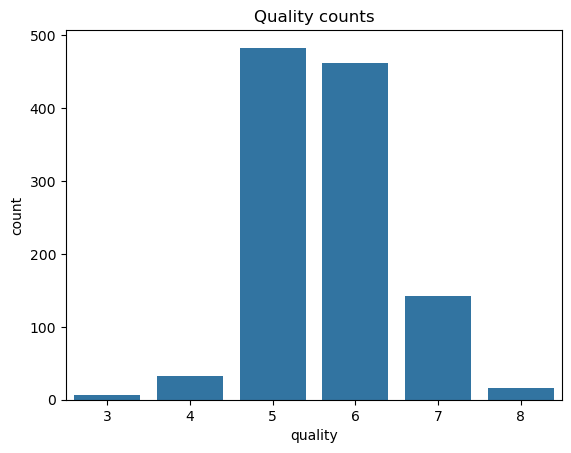

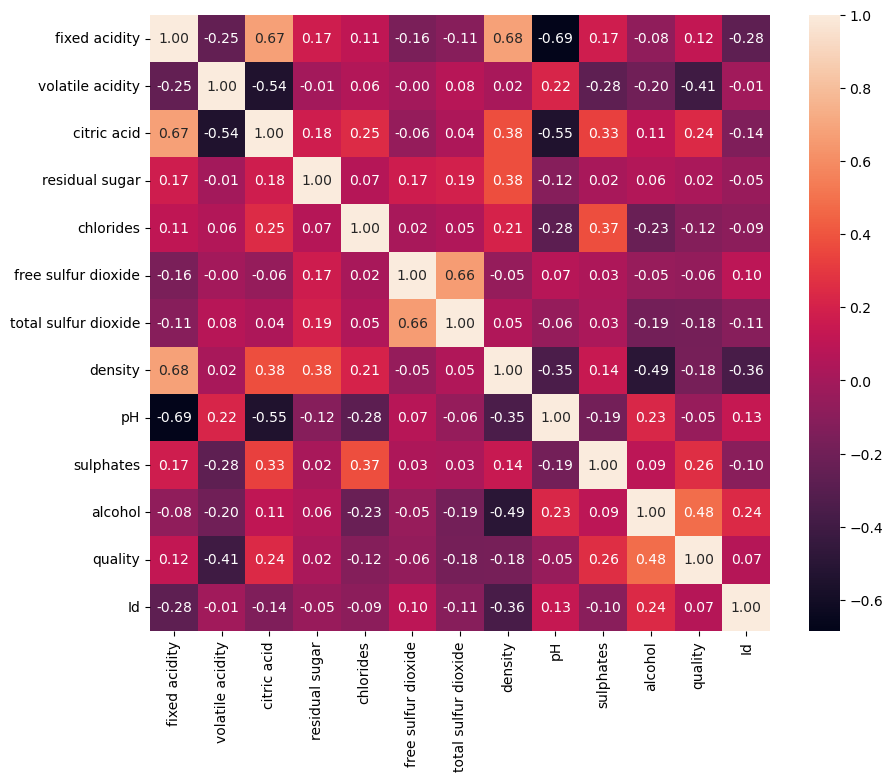

In [3]:
# distribution of quality
sns.countplot(x='quality', data=df)
plt.title('Quality counts')

# correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, fmt=".2f")


In [4]:
df['quality_label'] = (df['quality'] >= 7).astype(int)
df['quality_label'].value_counts()


quality_label
0    984
1    159
Name: count, dtype: int64

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(['quality','quality_label'], axis=1) if 'quality_label' in df else df.drop(['quality'], axis=1)
y = df['quality_label'] if 'quality_label' in df else df['quality']  # classification vs regression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y if 'quality_label' in df else None)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [7]:
import joblib
joblib.dump(scaler, '../model_scaler.pkl')


['../model_scaler.pkl']

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

models = {
    'LogReg': LogisticRegression(max_iter=1000),
    'RF': RandomForestClassifier(n_estimators=200, random_state=42)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1')  # or 'accuracy'
    print(name, 'F1 mean:', np.mean(scores))


LogReg F1 mean: 0.44651483781918566
RF F1 mean: 0.5623635078248015


In [9]:
best_model = RandomForestClassifier(n_estimators=200, random_state=42)
best_model.fit(X_train_scaled, y_train)
y_pred = best_model.predict(X_test_scaled)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.97      0.95       197
           1       0.77      0.62      0.69        32

    accuracy                           0.92       229
   macro avg       0.86      0.80      0.82       229
weighted avg       0.92      0.92      0.92       229



In [10]:
import joblib
joblib.dump(best_model, '../model.pkl')   # model file in project root


['../model.pkl']

In [11]:
joblib.dump(scaler, '../scaler.pkl')


['../scaler.pkl']